In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error

In [175]:
state_df = pd.read_csv('../data/state_df.csv',
                          parse_dates = ['Date'],
                          usecols = ['Date','NewDeaths','NewCases','RegionName','CountryName'],
                          index_col = 'Date')
country_df = pd.read_csv('../data/country_df.csv',
                          parse_dates = ['Date'],
                          usecols = ['Date','NewDeaths','NewCases','CountryName'],
                          index_col = 'Date')


In [176]:
usa_df = country_df[country_df['CountryName'] == 'United States'].iloc[:-1]
usa_df.index.freq = 'D'

In [170]:
usa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 61596 to 61948
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryName  353 non-null    object 
 1   Date         353 non-null    object 
 2   NewCases     353 non-null    float64
 3   NewDeaths    353 non-null    float64
dtypes: float64(2), object(2)
memory usage: 13.8+ KB


In [177]:
usa_df.index.freq

<Day>

In [178]:
usa_df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18'],
              dtype='datetime64[ns]', name='Date', length=353, freq='D')

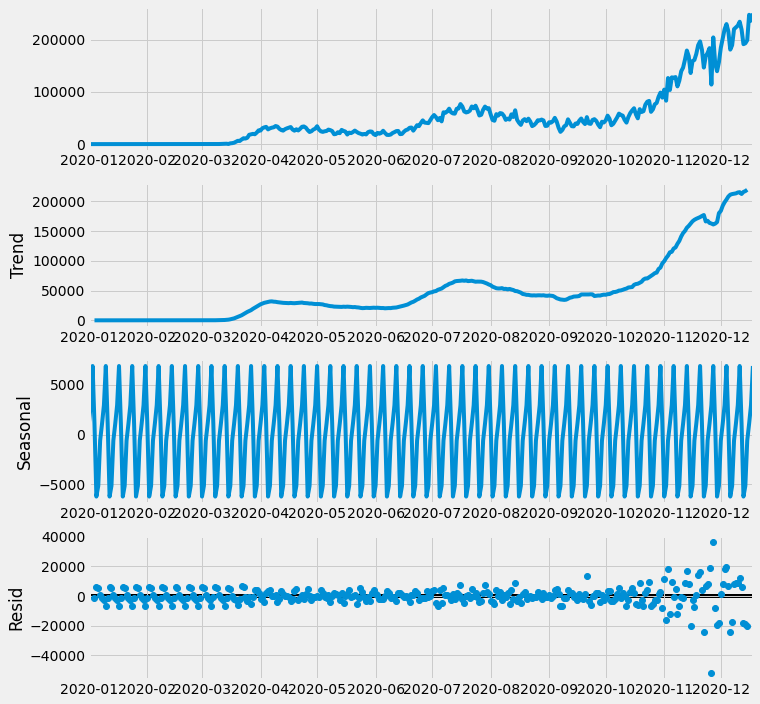

In [8]:
plt.rcParams['figure.figsize'] = [20,10]
results = seasonal_decompose(usa_df[['NewCases']])
results.plot().set_size_inches(10,10)


Above, we see a weekly seasonality in the decomposition.  We also see exploding variance in the residuals after November
Remove data up to march because it messes with the seasonality, and remove today

In [179]:
train_df = np.log(usa_df.loc[usa_df.index > '2020-03-31','NewCases'])
train_df

Date
2020-04-01    10.161342
2020-04-02    10.321770
2020-04-03    10.372553
2020-04-04    10.404717
2020-04-05    10.246971
                ...    
2020-12-14    12.169647
2020-12-15    12.199884
2020-12-16    12.418774
2020-12-17    12.372481
2020-12-18    12.428052
Freq: D, Name: NewCases, Length: 262, dtype: float64

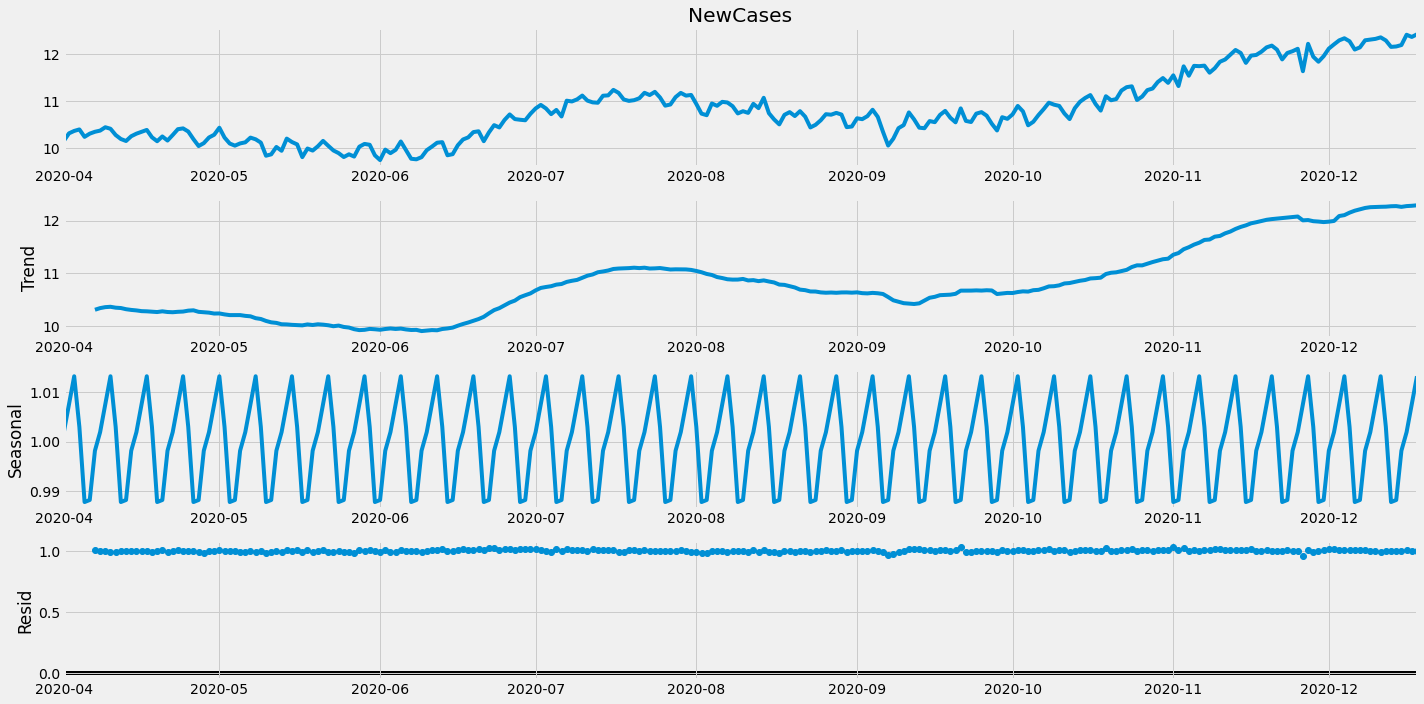

In [10]:
results = seasonal_decompose(train_df, two_sided = False,
                            model = 'multiplicative')
results.plot()
plt.show()

In [11]:
results.resid[:10]

Date
2020-04-01         NaN
2020-04-02         NaN
2020-04-03         NaN
2020-04-04         NaN
2020-04-05         NaN
2020-04-06         NaN
2020-04-07    1.006072
2020-04-08    1.001664
2020-04-09    1.001163
2020-04-10    0.991833
Name: resid, dtype: float64

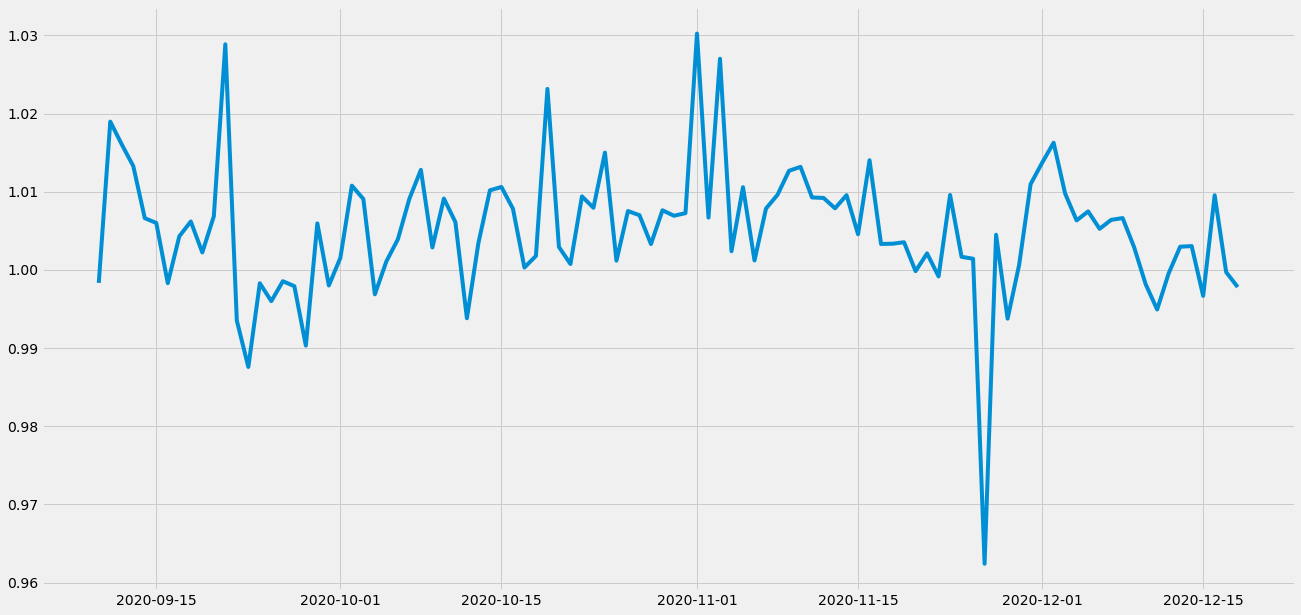

In [12]:
plt.plot(results.resid[-100:])

# Random Walk
for reference

Random Walk RMSE
0.6437500452813535


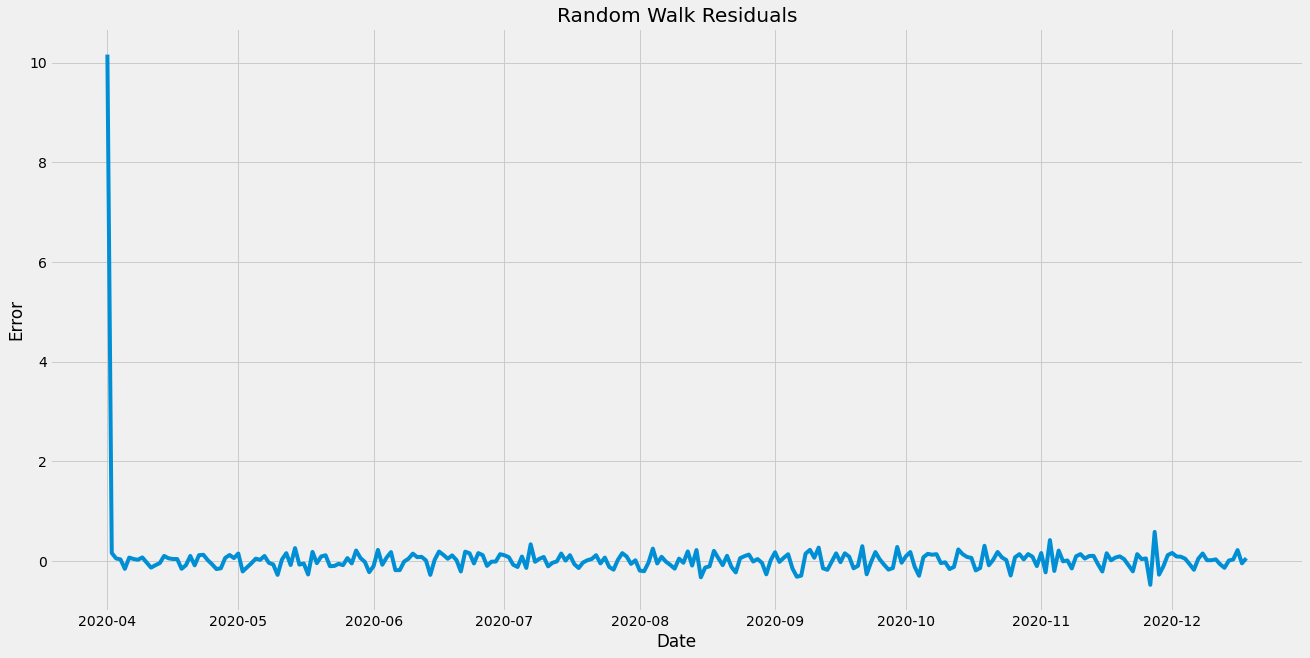

In [13]:
true = train_df
pred = true.shift().fillna(0)
print('Random Walk RMSE')
RW_RMSE = np.sqrt(mean_squared_error(true,pred))
print(RW_RMSE)
plt.plot(true.index,true-pred, label = 'Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Random Walk Residuals')
plt.show()

true = results.resid[6:].fillna(0)
pred = true.shift().fillna(0)
print('Random Walk RMSE')
RW_RMSE = np.sqrt(mean_squared_error(true,pred))
print(RW_RMSE)
plt.plot(true.index,true-pred, label = 'Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Random Walk Residuals')
plt.show()

# FSM
Our true FSM is a random walk, but let's do a simple ARIMA as well.
I suspect we will need a Sarima model, but lets start our FSM with an Arima model.

In [180]:
train = true[:-int(len(true)*.2)]
test = true[-int(len(true)*.2):]

# Training set predictions

FSM One-Step RMSE
0.1358682404811834
FSM Dynamic RMSE from August to November
0.6579361065033932


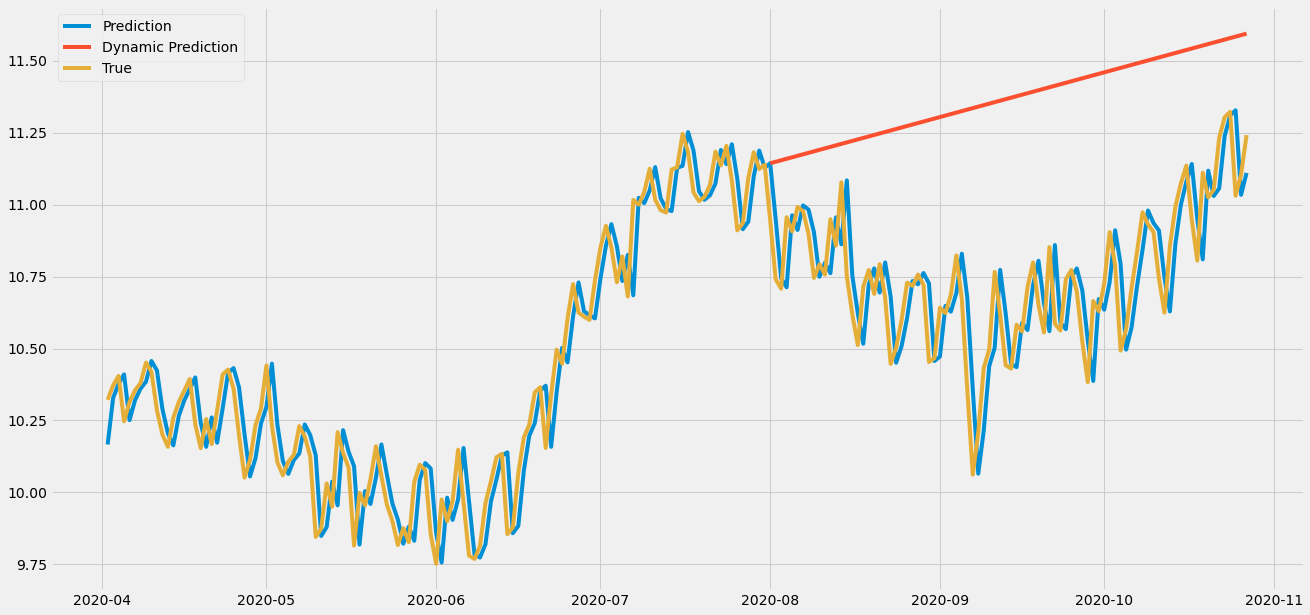

In [137]:
from statsmodels.tsa.arima_model import ARIMA
fsm = ARIMA(endog = train, order = (1,1,0), freq = 'd').fit()
y_hat = fsm.predict(typ='levels')
y_hat_dy = fsm.predict(start = '2020-08-01', 
                    end = train.index[-1], typ='levels', dynamic = True)
print('FSM One-Step RMSE')
FSM_RMSE = np.sqrt(mean_squared_error(train[1:], y_hat))
print(FSM_RMSE)
print('FSM Dynamic RMSE from August to November')
print(np.sqrt(mean_squared_error(train[train.index >= '2020-08-01'],y_hat_dy)))

fig, ax = plt.subplots()
ax.plot(y_hat, label = 'Prediction')
ax.plot(y_hat_dy, label = 'Dynamic Prediction')

ax.plot(train[1:], label = 'True')
plt.legend()

## FSM Evaluation
Our one-step ahead prediction accuracy beats the random walk, .135 to .643.  However, our dynamic prediction from August to November does not, with an RMSE of 658. It essentially predicts a straight line.

We are seeing the weekly seasonality again with these results, next I will try a SARIMA model to see if I can correct for, or incorporate that seasonality.  It may be that our ARIMA model has captured something of the trend in the data, but not the seasonality.